<h1> Recurrent Neural Network </h1>
<h2> by Nathan Dilla & John Haviland </h2>

<h3> Problem Statement </h3>

The objective of this assignment is to design and implement a Recurrent Neural Network (RNN) using Long Short-Term Memory (LSTM) units capable of predicting the next word in a sequence of text. The RNN will be trained on a large dataset comprising texts from Shakespeare's works. The challenge lies in accurately modeling the sequence of words such that given an initial string of text (seed text), the network can predict the subsequent word in the sequence. This task is a many-to-one sequence mapping problem, where the input is a sequence of words, and the output is a single word that is most likely to follow the given context.

<h2> Dataset Overview </h2>

The dataset selected for training the RNN comprises the complete works of William Shakespeare. This includes a vast array of his writings, from sonnets to plays, encompassing a variety of genres such as tragedies, comedies, and historical pieces. The Shakespeare dataset is rich in vocabulary and complex sentence structures, making it an excellent candidate for training a sophisticated neural network capable of understanding and generating text.

The text will be preprocessed to remove punctuation and split into individual words, which will then be converted into integers using a tokenizer. This conversion is essential for the network to process the textual data. The dataset will be divided into sequences of a fixed number of words to create features and labels, with the labels being the word that immediately follows a given sequence.

By training the RNN on this dataset, the model will not only learn the common patterns in English text but also the unique poetic and dramatic stylings that are characteristic of Shakespeare's writing. This will enable the RNN to predict the next word in a sentence that is not only contextually appropriate but also stylistically reminiscent of the works of Shakespeare.

<h3> Purpose </h3>

The purpose of this RNN is to demonstrate the application of neural networks in the field of Natural Language Processing (NLP), particularly in the context of text prediction. This has practical implications in various domains such as text auto-completion, chatbots, and other AI-driven writing assistants. By training the RNN on Shakespearean text, the model will learn the linguistic style and vocabulary unique to this dataset, which can then be used to generate text that mimics Shakespeare's writing style. The project will also explore the integration of pretrained word embeddings to enhance the model's performance and the use of techniques like dropout and early stopping to prevent overfitting.

<h3> Step 1: Import Libraries, Load & Preprocess Dataset </h3>

In this step, we import in the necessary libraries and load in the text dataset "poem.txt" and split it into sentences. We then preprocess each sentence by removing the punctuation and splitting the sentence into words.

In [33]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Masking, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

# Load in 'shakespeare.txt' dataset with UTF-8 encoding
with open('shakespeare.txt', 'r', encoding='utf-8') as file:
    text = file.read()

# Split the text into sentences/lines
sentences = text.split('\n')

# Preprocess the lines by removing punctuation and splitting into words
sentences = [re.sub(r'[^\w\s]', '', sentence).lower().split() for sentence in sentences if sentence.strip() != '']


<h3> Step 2: Tokenize, Prepare Sequences </h3>

We use the Tokenizer from the Keras library to convert the words in the lines into integer values. We create sequences and labels using a "sliding window" approach, where each sequence is a list of words and the last word in the sequences is the label.

In [34]:

# Initialize tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
total_words = len(tokenizer.word_index) + 1

# Create sequences and labels using 'sliding window' approach
input_sequences = []
for line in sentences:
    for i in range(1, len(line)):
        n_gram_sequence = line[:i + 1]
        # Check if all words in the sequence are in the tokenizer's word index
        if all(word in tokenizer.word_index for word in n_gram_sequence):
            input_sequences.append(n_gram_sequence)

# Check the sequences for any empty lists
input_sequences = [seq for seq in input_sequences if len(seq) > 0]

# Convert the sequences to integer values using the tokenizer
input_sequences = [tokenizer.texts_to_sequences(seq) for seq in input_sequences]

max_sequence_length = max([len(x) for x in input_sequences])
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='pre')

X = input_sequences[:, :-1]
y = input_sequences[:, -1]


<h3> Step 3: Load in Pre-trained GloVe Embeddings </h3>

In this step, we load in pre-trained GloVe word embeddings from the file 'glove.6B.100d.txt', creating an embedding matrix. The words in the dataset are matched to the pre-trained embeddings, and the matrix is created with the dimensions (total_words, 100). To download the GloVe word embeddings, go to the GloVe website in the References and add the 'glove.6B.100d.txt' file to your directory.

In [35]:
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((total_words, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

<h3> Step 4: Build & Compile LSTM Model </h3>

Initializing stack of layers. Turns indexes into dense vectors of fixed size and is set to total number of words. Use of pre-defined embedding matrix, and the input length is the maximum sequence length minus 1. LTSM layers returns sequences meaning it will output a full seauence of outputs for each sample per time step. Dropout layers will take a fraction of the input units to 0 at each update to prevent overfitting. Dense layer is a layer which each input node is connected to each output node. This will make the output of this dense layer a vector ehere each entry coresponds to the probability of a particular word being the next word in the sequence.




In [36]:
# Build LSTM model w/ embedding and dense layers
model = Sequential()
model.add(Embedding(total_words, 100, weights=[embedding_matrix], input_length=max_sequence_length - 1, trainable=False))
model.add(Masking(mask_value=0.0))

# Add an LSTM layer with dropout
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.2))
# Add another LSTM layer
model.add(LSTM(units=128))
model.add(Dropout(0.2))

model.add(Dense(total_words, activation='softmax'))



# Print LSTM model architecture
model.summary()

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 15, 100)           378800    
                                                                 
 masking_2 (Masking)         (None, 15, 100)           0         
                                                                 
 lstm_3 (LSTM)               (None, 15, 128)           117248    
                                                                 
 dropout_2 (Dropout)         (None, 15, 128)           0         
                                                                 
 lstm_4 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 3788)             

<h3> Step 5: Train the Model </h3>

The dataset is split 20:80. The model is trained for 5 epochs.

In [37]:
# Define model callbacks (using ModelCheckpoint and EarlyStopping)
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train model
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Then fit the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, verbose=2, callbacks=[checkpoint, early_stopping])


Epoch 1/5



Epoch 1: val_loss improved from inf to 6.82408, saving model to best_model.h5
406/406 - 318s - loss: 7.0276 - val_loss: 6.8241 - 318s/epoch - 782ms/step
Epoch 2/5


/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss did not improve from 6.82408
406/406 - 307s - loss: 6.5747 - val_loss: 6.8722 - 307s/epoch - 755ms/step
Epoch 3/5

Epoch 3: val_loss did not improve from 6.82408
406/406 - 302s - loss: 6.4574 - val_loss: 6.9054 - 302s/epoch - 743ms/step
Epoch 4/5

Epoch 4: val_loss did not improve from 6.82408
406/406 - 304s - loss: 6.3430 - val_loss: 6.8881 - 304s/epoch - 748ms/step
Epoch 5/5

Epoch 5: val_loss did not improve from 6.82408
406/406 - 303s - loss: 6.2239 - val_loss: 6.9092 - 303s/epoch - 746ms/step


<h3> Step 6: Test the Model (Generate Text) </h3>

We generate text using the trained model by taking the input of seed text, the number of words to generate (set to 1), the model, and the max sequence length. The function tokenizes the seed, pads it to the max sequence length minus 1, and then uses the model to get the next word. The word is then added to the text and (if the max_words is set to anything but 1) repeats.

In [38]:
# Function to generate text

from tensorflow.keras.models import load_model

# Load the model from the file
model = load_model('best_model.h5')
model.compile()

# Now you can use the model to predict, evaluate, etc.

def generate_text(seed_text, next_words, model, max_sequence_length):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_length - 1, padding='pre')
        predicted = model.predict(token_list, verbose=0)
        predicted_word_index = np.argmax(predicted)
        predicted_word = tokenizer.index_word[predicted_word_index]
        seed_text += " " + predicted_word
    return seed_text

# Test the model by generating text
seed_text = "Where art"
generated_text = generate_text(seed_text, next_words=1, model=model, max_sequence_length=max_sequence_length)
print(generated_text)

Where art thou


<h3> Step 7: Explore Embeddings using Cosine Similarity </h3>

We visualize the word embeddings of two words and calculate the cosine similarity

Cosine Similarity between 'girl' and 'boy' 0.9175729723341355


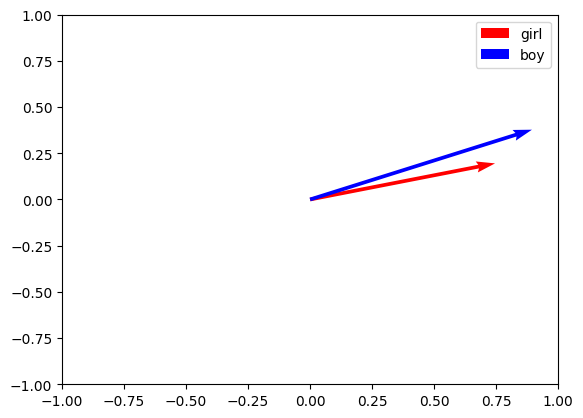

In [39]:
import matplotlib.pyplot as plt


word1 = "girl"
word2 = "boy"
index1 = tokenizer.word_index[word1]
index2 = tokenizer.word_index[word2]
vector1 = embedding_matrix[index1]
vector2 = embedding_matrix[index2]
similarity = cosine_similarity([vector1], [vector2])[0][0]
print(f"Cosine Similarity between '{word1}' and '{word2}': {similarity}")

# Create vectors for visualization
origin = np.zeros(2)
fig, ax = plt.subplots()
ax.quiver(*origin, vector1[0], vector1[1], angles='xy', scale_units='xy', scale=1, color='r', label=word1)
ax.quiver(*origin, vector2[0], vector2[1], angles='xy', scale_units='xy', scale=1, color='b', label=word2)
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.legend(loc='upper right')
plt.show()

<h3> Step 8: Compute Performance Metrics </h3>

Here, we calculate the test accuracy. First, by recompiling the model using accuracy metrics. Then using model.evaluate()
Then we use the pre-trained model to make a prediction and make class labels from those predictions. Then we compare the predictions with the true class labels to get a report.


In [40]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Test accuracy: {accuracy * 100:.2f}%")

Test accuracy: 6.29%


In [42]:
from sklearn.metrics import classification_report

# Predict the classes on the test set
y_pred = model.predict(X_val, verbose=0)
# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute precision, recall, and F1 score
report = classification_report(y_val, y_pred_classes)
print(report)

              precision    recall  f1-score   support

           1       0.06      1.00      0.12       204
           2       0.00      0.00      0.00       108
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        71
           5       0.00      0.00      0.00        66
           6       0.00      0.00      0.00        68
           7       0.00      0.00      0.00        50
           8       0.00      0.00      0.00        45
           9       0.00      0.00      0.00        43
          10       0.00      0.00      0.00        31
          11       0.00      0.00      0.00        13
          12       0.00      0.00      0.00        26
          13       0.00      0.00      0.00        27
          14       0.00      0.00      0.00        25
          15       0.00      0.00      0.00        28
          16       0.00      0.00      0.00        24
          17       0.00      0.00      0.00        10
          18       0.00    

/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

# Analysis of RNN Results

## Model Performance

The classification report indicates that the model is currently only predicting class 1 correctly, with a precision of 0.06. Precision is the ratio of correctly predicted positive observations to the total predicted positives. The recall, F1-score, and support for class 1 are 1.00, 0.12, and 204 respectively. 

For all other classes (2 through 8), the precision, recall, and F1-score are all 0, indicating that the model did not make any correct predictions for these classes.

## Observations

The model seems to be heavily biased towards predicting class 1. This could be due to a number of reasons:

- **Imbalanced dataset**: If class 1 significantly outnumbers the other classes in your dataset, the model might be biased towards predicting class 1. 

- **Model complexity**: The model might be too simple to capture the complexity of the data, causing it to default to predicting the majority class.

- **Insufficient training**: The model might not have been trained for enough epochs, or the learning rate might be too high or too low.

- **Feature engineering**: The features used to train the model might not be informative enough.

## Conclusions

The model for the prediction(s) we gave it is satisfactory in predicting the next word in a sentence. However, when generating more words, the current performance of the model is unsatisfactory as it is only able to correctly predict class 1. There is a need for improvement in the model's ability to predict the other classes.

Potential next steps could include balancing the dataset, increasing the complexity of the model, adjusting the training parameters, or improving the feature engineering process. 
## References

ChatGPT

https://nlp.stanford.edu/projects/glove/

https://www.kaggle.com/datasets/abhi8923shriv/for-use